In [1]:
# I like to start by checking if the GPU was initiated succesfully,
# and by seeing the tensroflow and python versions being used
# by the notebook.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
import os, sys, tarfile, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 5),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8977291533827439140
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 15174568725125077361
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python


In [2]:
# Read the Lab41 dataset into 
# train_Y, cv_Y, test_Y
# train_Y_indices, cv_Y_indices, test_Y_indices

start = time.time()
#...................................................

RATINGS_PATH = './data_ml-20m/ratings.csv'
MOVIES_PATH = './data_ml-20m/movies.csv'

#...................................................

with open(RATINGS_PATH) as f:
    ratings = f.readlines()

with open(MOVIES_PATH) as f:
    movies = f.readlines()

#...................................................

# mapping from movie ID (as described in 'movies.csv'), to index in matrix V
from_mID_2_idx = {}
for i, row in enumerate(movies[1:]):
    mID = int(row.split(',')[0])
    from_mID_2_idx[mID] = i
    
#...................................................

n_users = 138493
n_movies = len(movies[1:]) # n_movies = 27278

N = len(ratings[1:])
Y_indices = np.zeros((N,2), dtype=np.int32)
Y = np.zeros(N)

# Read in Y and Y_indices which concists of all training, cv and test data
for i, row in enumerate(ratings[1:]):
    uID, mID, yij = [e for e in row.split(',')[:-1]]
    u_idx = int(uID) - 1
    v_idx = from_mID_2_idx[int(mID)]
    yij = float(yij)
    
    Y_indices[i] = [u_idx, v_idx]
    Y[i] = yij

    
#...................................................

# when the indices are not shuffled, U and V matrices get skewed and best mae_cv is about 0.8
Y_indices, Y = shuffler(Y_indices, Y)

train_Y_indices, train_Y, cv_Y_indices, cv_Y, test_Y_indices, test_Y = split_data(Y_indices, Y)

del Y, Y_indices

print_runtime(start)

Runtime: 1 min 20 sec


In [57]:
start = time.time()
#.............................................. 
# hyperparameters
BATCH_SIZE = 1024*16
LAMBDA = 0.0
k = 10 # an important hyperparameter.
#.............................................. 

Y = tf.placeholder(dtype=tf.float32, shape=(BATCH_SIZE,))
Y_indices = tf.placeholder(dtype=tf.int32, shape=(BATCH_SIZE,2))

# initialization of U and V is critical. 
# set mean=np.sqrt(mu/k) , where mu ~ 3 or 3.5
U = tf.Variable(tf.truncated_normal(shape=(n_users,k), mean=np.sqrt(3.5/k), stddev=0.2), dtype=tf.float32)
V = tf.Variable(tf.truncated_normal(shape=(n_movies,k), mean=np.sqrt(3.5/k), stddev=0.2), dtype=tf.float32)
alpha1 = tf.Variable(-0.1, dtype=tf.float32)
alpha2 = tf.Variable(-0.1, dtype=tf.float32)
# weights for cross-features
UV_xft_weights = tf.Variable(tf.truncated_normal(shape=(k,k), mean=-1*np.sqrt(1./k), stddev=0.2), dtype=tf.float32)
UU_xft_weights = tf.Variable(tf.truncated_normal(shape=(k,k), mean=-1*np.sqrt(1./k), stddev=0.2), dtype=tf.float32)
VV_xft_weights = tf.Variable(tf.truncated_normal(shape=(k,k), mean=-1*np.sqrt(1./k), stddev=0.2), dtype=tf.float32)

#.............................................. 

sliced_U, sliced_V = get_sliced_UV(Y_indices, Y, U, V, k, BATCH_SIZE)

# the term `tf.reduce_sum(U**2)` without passing an axis parameter sums up all the elements of matrix U**2.
# Return value is a scalar.
reg = LAMBDA*(tf.reduce_sum(U**2) + tf.reduce_sum(V**2)) / (BATCH_SIZE*k)

# the term `tf.multiply(sliced_U, sliced_V)` is elementwise multiplication.
# Applying tf.reduce_sum(M, axis=1)--where M is a matrix--will sum all rows and return a column vector.
# Here, Y_pred is a column vector of ratings corresponding to Y_indices
lin = tf.reduce_sum(tf.multiply(sliced_U, sliced_V), axis=1)

u_cdot_v_square = tf.square(tf.multiply(sliced_U, sliced_V)) 
# non-linear terms: np.multiply(U[i,:], V[j,:])**2
nonlin = tf.reduce_sum(u_cdot_v_square, axis=1)

xft = UV_xft_weights[0,1] * tf.multiply(tf.transpose(sliced_U)[0],tf.transpose(sliced_V)[1])
for p in range(k):
    for q in range(0, k):
        xft += UV_xft_weights[p,q] * tf.multiply(tf.transpose(sliced_U)[p], tf.transpose(sliced_V)[q])

for p in range(k):
    for q in range(p, k):
        xft += UU_xft_weights[p,q] * tf.multiply(tf.transpose(sliced_U)[p], tf.transpose(sliced_U)[q])

for p in range(k):
    for q in range(p, k):
        xft += VV_xft_weights[p,q] * tf.multiply(tf.transpose(sliced_V)[p], tf.transpose(sliced_V)[q])


# Y_pred = lin + alpha1*(nonlin) + alpha2*(xft)
Y_pred = lin +  alpha1 * xft
Y_pred = tf.sigmoid(Y_pred) * 5

# define loss function as square of L2-norm of difference btw actual and predicted ratings
loss = tf.sqrt(tf.reduce_sum((Y - Y_pred)**2)/BATCH_SIZE)# + reg

# Define train op.
lr = 0.01
train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

#.............................................. 
print_runtime(start) 

Runtime: 0 min 9 sec


NUM_EPOCHS: 10
k: 10
lr: 0.01
n_batches: 781

New epoch: 1 ******************************
batch_no: 781, _loss estimate: 0.8911, t= 71.75 sec
mae_train: 0.6157, **mae_cv: 0.6366**, mae_test: 0.6365, alpha1: 0.1672, alpha2: -0.1000

New epoch: 2 ******************************
batch_no: 781, _loss estimate: 0.8049, t= 60.93 sec
mae_train: 0.5827, **mae_cv: 0.6217**, mae_test: 0.6216, alpha1: 0.1691, alpha2: -0.1000

New epoch: 3 ******************************
batch_no: 781, _loss estimate: 0.7774, t= 60.91 sec
mae_train: 0.5676, **mae_cv: 0.6178**, mae_test: 0.6177, alpha1: 0.1778, alpha2: -0.1000

New epoch: 4 ******************************
batch_no: 781, _loss estimate: 0.7623, t= 61.21 sec
mae_train: 0.5598, **mae_cv: 0.6171**, mae_test: 0.6169, alpha1: 0.1917, alpha2: -0.1000

New epoch: 5 ******************************
batch_no: 781, _loss estimate: 0.7529, t= 61.29 sec
mae_train: 0.5545, **mae_cv: 0.6165**, mae_test: 0.6164, alpha1: 0.2038, alpha2: -0.1000

New epoch: 6 ***********

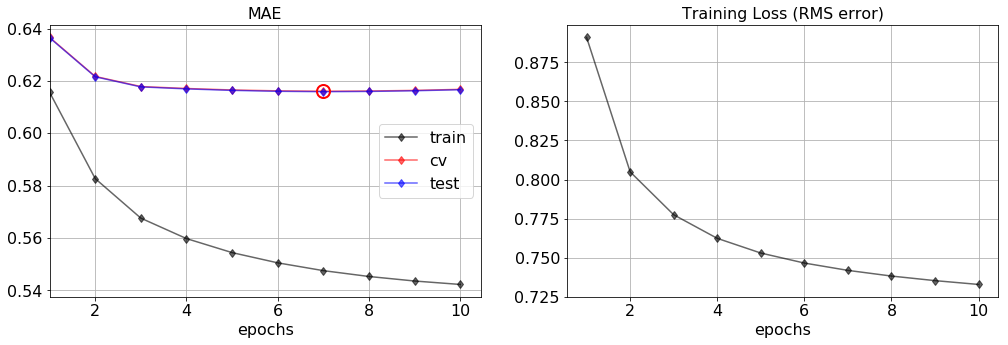

In [58]:
start = time.time()
#.............................................. 
NUM_EPOCHS = 10 
n_batches = len(train_Y) // BATCH_SIZE
init = tf.global_variables_initializer()
batch = Batch(train_Y_indices, train_Y, BATCH_SIZE=BATCH_SIZE)
epoch_end = time.time()
batch_no = 0
_loss = 0
mae_train_arr, mae_cv_arr , mae_test_arr, loss_arr = [], [], [], []

print('NUM_EPOCHS: {}\nk: {}\nlr: {}\nn_batches: {}'.format(NUM_EPOCHS, k, lr, n_batches))

with tf.Session() as sess:
    sess.run(init)
    while not (batch.epoch == NUM_EPOCHS and batch.last_batch==True):
        batch_Y_indices, batch_Y = batch.next()
        if not batch.broken:
            batch_no += 1
            # _bl is batch loss
            _, _bl = sess.run([train, loss], 
                                      feed_dict={Y_indices: batch_Y_indices, Y: batch_Y})
            
            _loss += _bl
            print("batch_no: {}, _loss estimate: {:6.4f}, t={:6.2f} sec".format(
                    batch_no, _loss/batch_no, time.time()-epoch_end), end='\r') 
            
        if batch.last_batch: 
            # fetch the state of U, V matrices at current epoch
            _U, _V, _alpha1, _alpha2 = sess.run([U, V, alpha1, alpha2]) 
            _, _mae_train = evaluate(sess, train_Y, train_Y_indices, Y_pred, Y_indices, Y, BATCH_SIZE)
            _, _mae_cv = evaluate(sess, cv_Y, cv_Y_indices, Y_pred, Y_indices, Y, BATCH_SIZE)
            preds, _mae_test = evaluate(sess, test_Y, test_Y_indices, Y_pred, Y_indices, Y, BATCH_SIZE)
            
            mae_train_arr.append(_mae_train)
            mae_cv_arr.append(_mae_cv)
            mae_test_arr.append(_mae_test)
            loss_arr.append(_loss/n_batches)
            mean_preds = np.mean(preds)

            # printing....
            print('\nmae_train: %6.4f, **mae_cv: %6.4f**, mae_test: %6.4f, alpha1: %6.4f, alpha2: %6.4f' % 
                  (_mae_train, _mae_cv, _mae_test, _alpha1, _alpha2))
            # print('(reg/_loss) fraction: %6.4f' %(sess.run(reg/_loss)))
            
            # resetting some iteration variables....
            batch_no = 0
            _loss = 0
            epoch_end = time.time()

#.............................................. 
# plotting....
ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr)
print_runtime(start)


n_batches: 781
k: 10
lr: 0.01
NUM_EPOCHS: 10
min(mae_train): 0.5423, **mae_cv: 0.6160**, mae_test: 0.6159


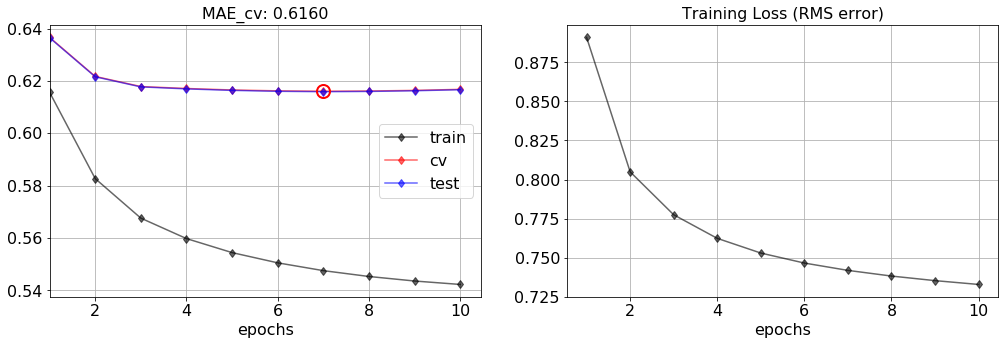

In [61]:
print('n_batches: {}\nk: {}\nlr: {}\nNUM_EPOCHS: {}'.format(n_batches, k, lr, NUM_EPOCHS))
i_min = np.argmin(mae_cv_arr)
print('min(mae_train): %6.4f, **mae_cv: %6.4f**, mae_test: %6.4f' % (min(mae_train_arr), mae_cv_arr[i_min], mae_test_arr[i_min]))
ax1, ax2 = plotter( mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr)
